# LSA

* Expand sample
* Can hold academic macro research unchanged
* Now examine changes between changing CB research and macro research
* Now examine test if this result isn't due to central bank research becoming more eclectic
* Now examine test if this result isn't due to academic research becoming more eclectic
* Now examine CB similarity before crisis
* CB:CB ave score before; CB:CB average score after
* ACA:CB ave score before; ACA:CB average score after

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')

#### Read in the central bank data
* drop undated papers
* only keep papers after 1999
* create a column with the central bank identifier

In [2]:
all_cb_data  = pd.read_csv("data.csv")
all_cb_data  = all_cb_data[all_cb_data.Year != "undated"]
all_cb_data  = all_cb_data[pd.to_numeric(all_cb_data.Year) > 1999]
all_cb_data.index = range(len(all_cb_data))

# add central bank identifiers
def cb_id(s):
    if 'Australia' in s:
        return 'RBA'
    elif 'US' in s:
        return 'US'
    elif 'European' in s:
        return 'ECB'
    elif 'Japan' in s:
        return 'BoJ'
    elif 'Canada' in s:
        return 'BoC'
    elif 'New Zealand' in s:
        return 'RBNZ'
    elif 'England' in s:
        return 'BoE'
    elif 'Sweden' in s:
        return 'Riksbank'
    elif 'Norges' in s:
        return 'Norges'
        
all_cb_data['Central_Bank'] = all_cb_data.ID.map(cb_id)

len(all_cb_data)

6637

In [3]:
# remove papers where the abstract is not available
all_cb_data = all_cb_data[all_cb_data.Abstract != 'No abstract available']
all_cb_data = all_cb_data[all_cb_data.Year >= '2006']
all_cb_data = all_cb_data.reset_index()
len(all_cb_data)

4937

#### Read in the academic papers
* Create a combined data frame with all papers

In [4]:
all_aca_data_1 = pd.read_csv("macro_data_resub_1.csv")
all_aca_data_1['Year'] = all_aca_data_1['Year'].str.replace('.', '')
all_aca_data_1   = all_aca_data_1[all_aca_data_1.Year >= '2006']
all_aca_data_2 = pd.read_csv("macro_data_resub_2.csv")
all_aca_data_2 = all_aca_data_2[all_aca_data_2.Year >= 2006]
all_aca_data   = all_aca_data_1.append(all_aca_data_2) 
all_aca_data = all_aca_data[(all_aca_data.ID != "Journal of Money, Credit and Banking")]
all_aca_data   = all_aca_data.reset_index()
len(all_aca_data)
all_aca_data['Year'] = all_aca_data['Year'].astype('int64')

In [5]:
# remove papers where the abstract is not available
all_aca_data = all_aca_data[all_aca_data.Abstract != 'No abstract is available for this item.']
all_aca_data = all_aca_data.reset_index()
len(all_aca_data)

6641

In [6]:
abs_raw   = all_cb_data.Abstract.append(all_aca_data.Abstract, ignore_index=True)

#### Preprocessing function

In [7]:
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# create English stop words list
en_stop = set(stopwords.words('english'))
# add context-specific stop words to list
en_stop = en_stop.union(["per","cent","one","two","three","four","five","six","seven","eight","nine","use",
                         "also","paper","results","evidence","suggests","implies","indicates","jel","find",
                         "finding",'hypothesis',"classification","area","effect","may","could","might"
                         ,"canada","canadian","australia","australian","japan","japanese","new zealand",
                         "swedish","sweden","norway","norwegian"])
    
def preprocess(s):
    
    # make lower case
    s = s.lower()
    
    # remove all numbers
    s = re.sub(r'[0-9]+', '', s)
    
    # create p_stemmer of class PorterStemmer
    p_stemmer  = PorterStemmer()
    
    # create lemmatizer of class WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # tokenize string
    token_pattern=r"(?u)\b\w\w+\b"
    token_pattern = re.compile(token_pattern)
    s = token_pattern.findall(s)

    # remove stop words from tokens
    s = [i for i in s if not i in en_stop]
    
#     # stem words
#     s = [p_stemmer.stem(i) for i in s] 

    # lemmatize words
    s = [lemmatizer.lemmatize(i) for i in s] 
    
    return s

In [8]:
abstracts = abs_raw.map(preprocess)

### Build corpus and reweight by tf-idf

In [9]:
from gensim import corpora
from gensim.models import TfidfModel

# build dictionary using all words
dictionary = corpora.Dictionary(abstracts)
print(dictionary)

# build corpus 
corpus = [dictionary.doc2bow(text) for text in abstracts]

#apply tf-idf
tfidf  = TfidfModel(corpus)  # fit model
corpus = tfidf[corpus]

Dictionary(16313 unique tokens: ['account', 'agreement', 'available', 'bargaining', 'caused']...)


#### Build LSA matrix and index
* Only use academic papers for the index

In [10]:
from gensim import models, similarities
from gensim.test.utils import common_corpus, common_dictionary

lsi        = models.LsiModel(corpus, id2word=dictionary, num_topics=300)
lsi_matrix = lsi[corpus]

# NB: the index should only include academic papers!!
index      = similarities.MatrixSimilarity(lsi[corpus][len(all_cb_data):len(abstracts)]) 

In [11]:
#NB: the similarities should only be calculated for central bank papers!!

sims = []
for i in range(len(all_cb_data)): # From 0 to end of cb papers
    similarity = index[lsi_matrix[i]] 
    sims.append(sorted(enumerate(similarity), key=lambda item: -item[1])[0:4])

In [12]:
sims_top = []
for x in range(len(sims)):
    sims_top.append([i[0:2] for i in sims[x]][0])
    
sims_ave = []
for x in range(len(sims)):
    sims_top5 = [i[1] for i in sims[x]]
    sims_ave.append(sum(sims_top5) / len(sims_top5)) 

In [13]:
from operator import itemgetter

sorted(sims_top,key=itemgetter(1))[0]

(326, 0.3124023)

In [14]:
# Sims = for each cb paper, its five most similar academic papers (starting from a count of 0)

#### Build LSA matrix and index
* Now only use central bank papers for the index

In [15]:
# NB: the index should only include central bank papers!!
index_cb      = similarities.MatrixSimilarity(lsi[corpus][0:len(all_cb_data)])

In [16]:
# NB: the index should only include central bank papers!!
index_aca     = similarities.MatrixSimilarity(lsi[corpus][len(all_cb_data):len(abstracts)])

In [17]:
#NB: the similarities should only be calculated for central bank papers!!
sims_cb = []
for i in range(len(all_cb_data)):
    similarity = index_cb[lsi_matrix[i]] 
    sims_cb.append(sorted(enumerate(similarity), key=lambda item: -item[1])[1:5]) #need to start the indexing at 1
                                                                                  #otherwise it's a perfect match!

In [18]:
#NB: the similarities should only be calculated for central bank papers!!
sims_aca = []
for i in range(len(all_aca_data)):
    similarity = index_aca[lsi_matrix[i]] 
    sims_aca.append(sorted(enumerate(similarity), key=lambda item: -item[1])[1:5]) #need to start the indexing at 1
                                                                                  #otherwise it's a perfect match!

In [19]:
sims_top_cb = []
for x in range(len(sims_cb)):
    sims_top_cb.append([i[0:2] for i in sims_cb[x]][0])
    
sims_ave_cb = []
for x in range(len(sims_cb)):
    sims_top5 = [i[1] for i in sims_cb[x]]
    sims_ave_cb.append(sum(sims_top5) / len(sims_top5)) 

In [20]:
sims_top_aca = []
for x in range(len(sims_aca)):
    sims_top_aca.append([i[0:2] for i in sims_aca[x]][0])
    
sims_ave_aca = []
for x in range(len(sims_aca)):
    sims_top5 = [i[1] for i in sims_aca[x]]
    sims_ave_aca.append(sum(sims_top5) / len(sims_top5)) 

#### Look at an example comparing a CB paper to an academic paper 
* Reported in the Appendix of the paper

In [21]:
print(abs_raw[200],"=",abs_raw[len(all_cb_data)+sims_top[200][0]])

The Phillips curve has been much flatter in the past twenty years than in the preceding decades. We consider two hypotheses. One is that prices at the microeconomic level are stickier than they used to be---in the context of the canonical Calvo model, firms are adjusting prices less often. The other is that the expectations of firms and households about future inflation are now less well informed by macroeconomic conditions; because expectations are important in the setting of current-period prices, inflation is therefore less sensitive to macroeconomic conditions. To distinguish between our two hypotheses, we bring to bear information on inflation expectations from surveys, which allow us to distinguish changes in the sensitivity of inflation to economic conditions conditioning on expectations from changes in the sensitivity of expectations themselves to economic conditions. We find that, with some measures, expectations are less tied to economic conditions than in the past, and thus 

In [22]:
print(abs_raw[378],"=",abs_raw[len(all_cb_data)+sims_top[378][0]])

The widespread emergence of intangible technologies in recent decades may have significantly hurt output growth--even when these technologies replaced considerably less productive tangible technologies--because of structurally low interest rates caused by demographic forces. This insight is obtained in a model in which intangible capital cannot attract external finance, firms are credit constrained, and there is substantial dispersion in productivity. In a tangibles-intense economy with highly leveraged firms, low rates enable more borrowing and faster debt repayment, reduce misallocation, and increase aggregate output. An increase in the share of intangible capital in production reduces the borrowing capacity and increases the cash holdings of the corporate sector, which switches from being a net borrower to a net saver. In this intangibles-intense economy, the ability of firms to purchase intangible capital using retained earnings is impaired by low interest rates, because low rates 

In [23]:
sims_top_df                            = pd.DataFrame(sims_top)
sims_top_df["distance"]                = (sims_top_df[1])
sims_top_df["distance_std"]            = (sims_top_df[1]-sims_top_df[1].mean())/sims_top_df[1].std()
sims_top_df['year']                    = all_cb_data.Year
sims_top_df['CB']                      = all_cb_data.Central_Bank
sims_top_df['paper_indicator']         = np.ones(len(sims_top_df))

sims_ave_df                            = pd.DataFrame(sims_ave)
sims_ave_df["distance"]                = (sims_ave_df[0])
sims_ave_df["distance_std"]            = (sims_ave_df[0]-sims_ave_df[0].mean())/sims_ave_df[0].std()
sims_ave_df['year']                    = all_cb_data.Year
sims_ave_df['CB']                      = all_cb_data.Central_Bank

sims_top_cb_df                         = pd.DataFrame(sims_top_cb)
sims_top_cb_df["distance"]             = (sims_top_cb_df[1])
sims_top_cb_df["distance_std"]         = (sims_top_cb_df[1]-sims_top_cb_df[1].mean())/sims_top_cb_df[1].std()
sims_top_cb_df['year']                 = all_cb_data.Year
sims_top_cb_df['CB']                   = all_cb_data.Central_Bank
sims_top_cb_df['paper_indicator']      = np.zeros(len(sims_top_cb_df))

sims_ave_cb_df                            = pd.DataFrame(sims_ave_cb)
sims_ave_cb_df["distance"]                = (sims_ave_cb_df[0])
sims_ave_cb_df["distance_std"]            = (sims_ave_cb_df[0]-sims_ave_cb_df[0].mean())/sims_ave_cb_df[0].std()
sims_ave_cb_df['year']                    = all_cb_data.Year
sims_ave_cb_df['CB']                      = all_cb_data.Central_Bank

sims_top_aca_df                         = pd.DataFrame(sims_top_aca)
sims_top_aca_df["distance"]             = (sims_top_aca_df[1])
sims_top_aca_df["distance_std"]         = (sims_top_aca_df[1]-sims_top_aca_df[1].mean())/sims_top_aca_df[1].std()
sims_top_aca_df['year']                 = all_aca_data.Year
sims_top_aca_df['paper_indicator']      = np.zeros(len(sims_top_aca_df))+2

sims_ave_aca_df                            = pd.DataFrame(sims_ave_aca)
sims_ave_aca_df["distance"]                = (sims_ave_aca_df[0])
sims_ave_aca_df["distance_std"]            = (sims_ave_aca_df[0]-sims_ave_aca_df[0].mean())/sims_ave_aca_df[0].std()
sims_ave_aca_df['year']                    = all_aca_data.Year

sims_top_combined                      = sims_top_df.append(sims_top_cb_df)
sims_top_combined                      = sims_top_combined.append(sims_top_aca_df)
sims_top_combined.drop(["distance_std"], axis=1)
sims_top_combined["distance_std"]      = (sims_top_combined[1]-sims_top_combined[1].mean())/sims_top_combined[1].std()

#### Save data to csv for Stata modelling
* This is for the diff-in-diff regression

In [24]:
sims_top_combined.to_csv("combined_cosine_to_stata.csv", encoding='utf-8')
sims_top_combined_ave = sims_top_combined.groupby(['year','paper_indicator']).mean()["distance"] 
sims_top_combined_ave.to_csv("combined_cosine_to_stata_ave.csv", encoding='utf-8')
sims_top_df.to_csv("cosine_to_stata.csv", encoding='utf-8')

#### Parallel trends assumption

In [25]:
# from scipy import stats

# cb_top     = pd.DataFrame(sims_top_combined[pd.to_numeric(sims_top_combined.year)>2003])
# cb_top     = cb_top[cb_top['paper_indicator'] == 0].groupby(['year']).mean()["distance_std"]

# aca_top    = pd.DataFrame(sims_top_combined[pd.to_numeric(sims_top_combined.year)>2003])
# aca_top    = aca_top[aca_top['paper_indicator'] == 1].groupby(['year']).mean()["distance_std"]

# # Generated linear fit
# xi = np.arange(0,6)
# slope, intercept, r_value, p_value, std_err = stats.linregress(xi,cb_top[0:6])
# line_1 = slope*xi+intercept

# slope, intercept, r_value, p_value, std_err = stats.linregress(xi,aca_top[0:6])
# line_2 = slope*xi+intercept

# #Charting
# plt.style.use('fivethirtyeight')

# fig, ax1 = plt.subplots(figsize=(10,6),facecolor='white')

# color = 'tab:red'
# ax1.set_ylabel('Bank-to-bank similarity', color=color, fontsize=22)
# ax1.plot(cb_top, color=color)
# ax1.plot(line_1, '--',alpha=0.7,color=color)
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.set_facecolor('white')
# ax1.tick_params(axis = 'both', which = 'major', labelsize = 22)
# ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
# ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
# ax1.grid(False)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('Bank-to-academic similarity', color=color, fontsize=22)  # we already handled the x-label with ax1
# ax2.plot(aca_top, color=color)
# ax2.plot(line_2, '--',alpha=0.7,color=color)
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_facecolor('white')
# ax2.tick_params(axis = 'both', which = 'major', labelsize = 22)
# ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
# ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
# ax2.grid(False)

# x0 = int(ax1.get_xlim()[0]) # left boundary of x-axis (plot reference point)
# gfc = x0+5

# ax1.axvline(gfc,ls='--',c='k',lw=3,label='test start')
# ax2.axvline(gfc,ls='--',c='k',lw=3,label='test start')

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('parallel.pdf',facecolor=fig.get_facecolor(), edgecolor='none')
# plt.show()

#### Distance to frontier macro research

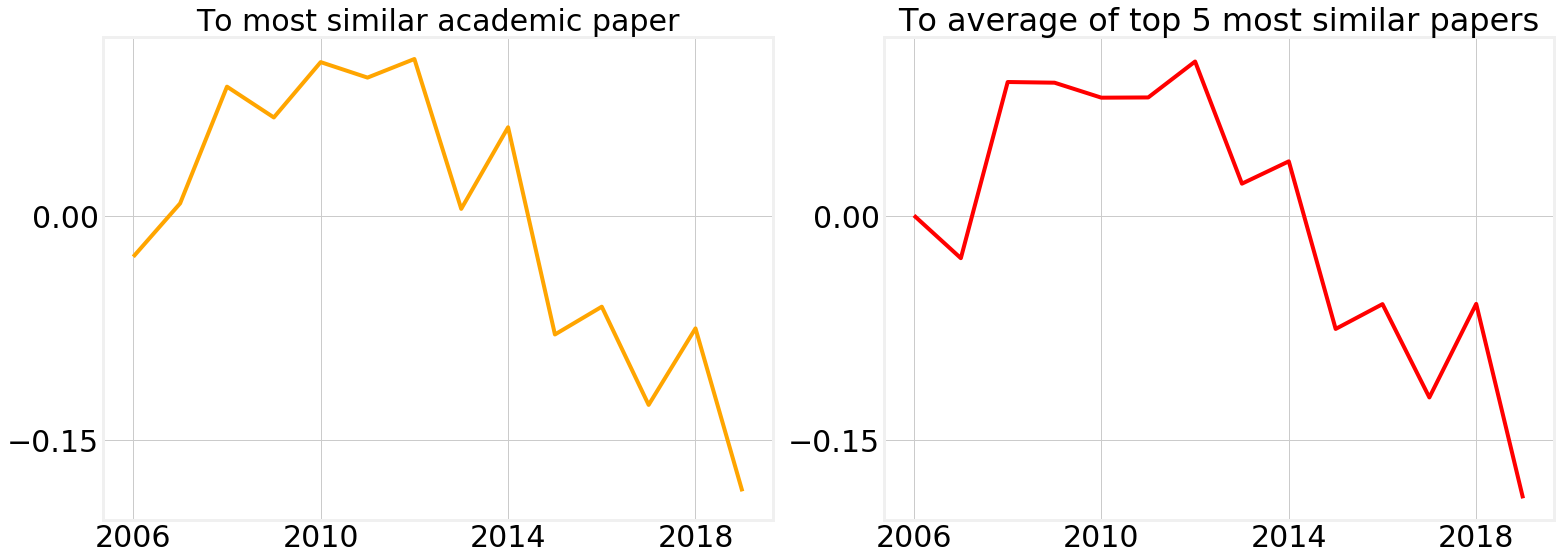

In [26]:
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(22,8),facecolor='white')

ax1 = plt.subplot2grid(shape=(1,2), loc=(0,0), colspan=1)
ax2 = plt.subplot2grid(shape=(1,2), loc=(0,1), colspan=1, sharey=ax1)

for ax in [ax1, ax2]:
    # Clear x axis ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.tick_params(axis = 'both', which = 'major', labelsize = 30)
    #ax.grid(False)
    ax.set_facecolor('white')


top    = sims_top_df.groupby(['year']).mean()["distance_std"]
ave    = sims_ave_df.groupby(['year']).mean()["distance_std"]

ax1.plot(top, color="orange")
ax1.set_title("To most similar academic paper",fontsize=30)

ax2.plot(ave, color="red")
ax2.set_title("To average of top 5 most similar papers",fontsize=32)

x0 = int(ax1.get_xlim()[0]) # left boundary of x-axis (plot reference point)
gfc = x0+4

# ax1.axvline(gfc,ls='--',c='k',lw=3,label='test start')
# ax2.axvline(gfc,ls='--',c='k',lw=3,label='test start')

# a = x0
# b = x0+3
# c = x0+9
# d = x0+13
# ax1.axvspan(a, b, color='grey', alpha=0.2, lw=0)
# ax1.axvspan(c, d, color='grey', alpha=0.2, lw=0)
# ax2.axvspan(a, b, color='grey', alpha=0.2, lw=0)
# ax2.axvspan(c, d, color='grey', alpha=0.2, lw=0)

plt.tight_layout()
plt.savefig('cosine_rev.pdf',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

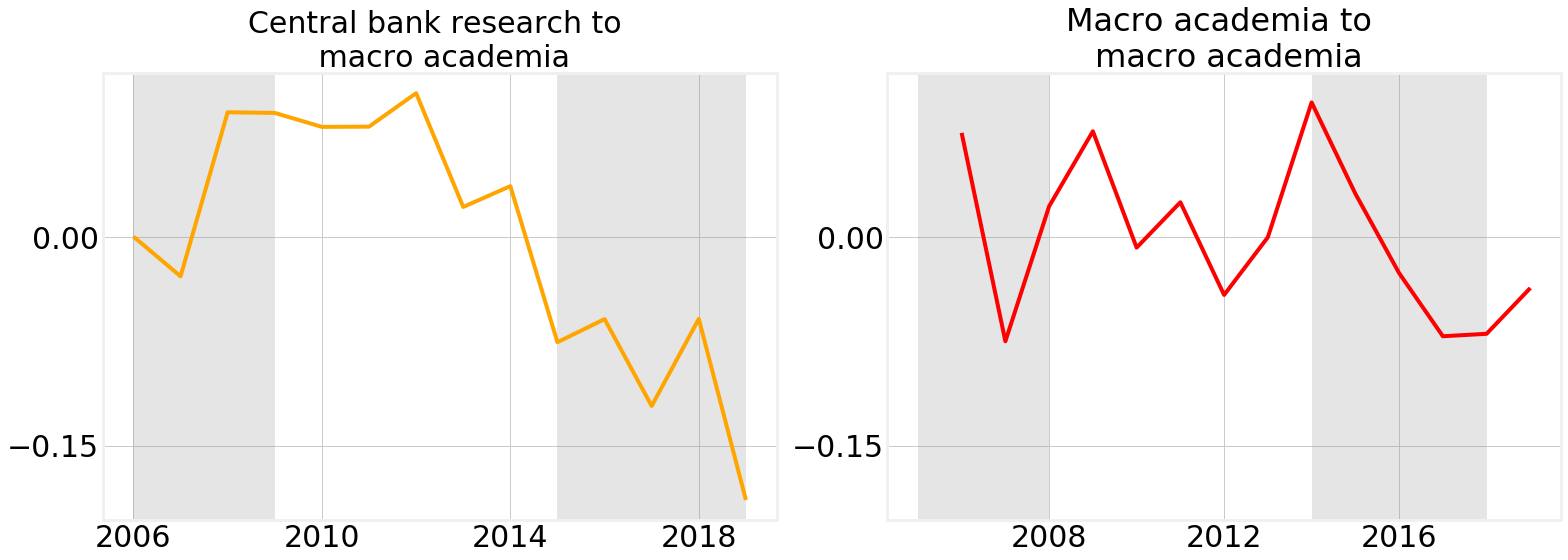

In [27]:
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(22,8),facecolor='white')

ax1 = plt.subplot2grid(shape=(1,2), loc=(0,0), colspan=1)
ax2 = plt.subplot2grid(shape=(1,2), loc=(0,1), colspan=1, sharey=ax1)

for ax in [ax1, ax2]:
    # Clear x axis ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.tick_params(axis = 'both', which = 'major', labelsize = 30)
    #ax.grid(False)
    ax.set_facecolor('white')

sims_ave_aca_df = sims_ave_aca_df[sims_ave_aca_df.year <= 2019]
cb_aca      = sims_ave_df.groupby(['year']).mean()["distance_std"]
aca_aca     = sims_ave_aca_df.groupby(['year']).mean()["distance_std"]

ax1.plot(cb_aca, color="orange")
ax1.set_title("Central bank research to \n macro academia",fontsize=30)

ax2.plot(aca_aca, color="red")
ax2.set_title("Macro academia to \n macro academia",fontsize=32)

x0 = int(ax1.get_xlim()[0]) # left boundary of x-axis (plot reference point)
x1 = int(ax2.get_xlim()[0]) # left boundary of x-axis (plot reference point)
a = x0
b = x0+3
c = x0+9
d = x0+13
e = x1
f = x1+3
g = x1+9
h = x1+13
ax1.axvspan(a, b, color='grey', alpha=0.2, lw=0)
ax1.axvspan(c, d, color='grey', alpha=0.2, lw=0)
ax2.axvspan(e, f, color='grey', alpha=0.2, lw=0)
ax2.axvspan(g, h, color='grey', alpha=0.2, lw=0)

plt.tight_layout()
plt.savefig('cosine_rev.pdf',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

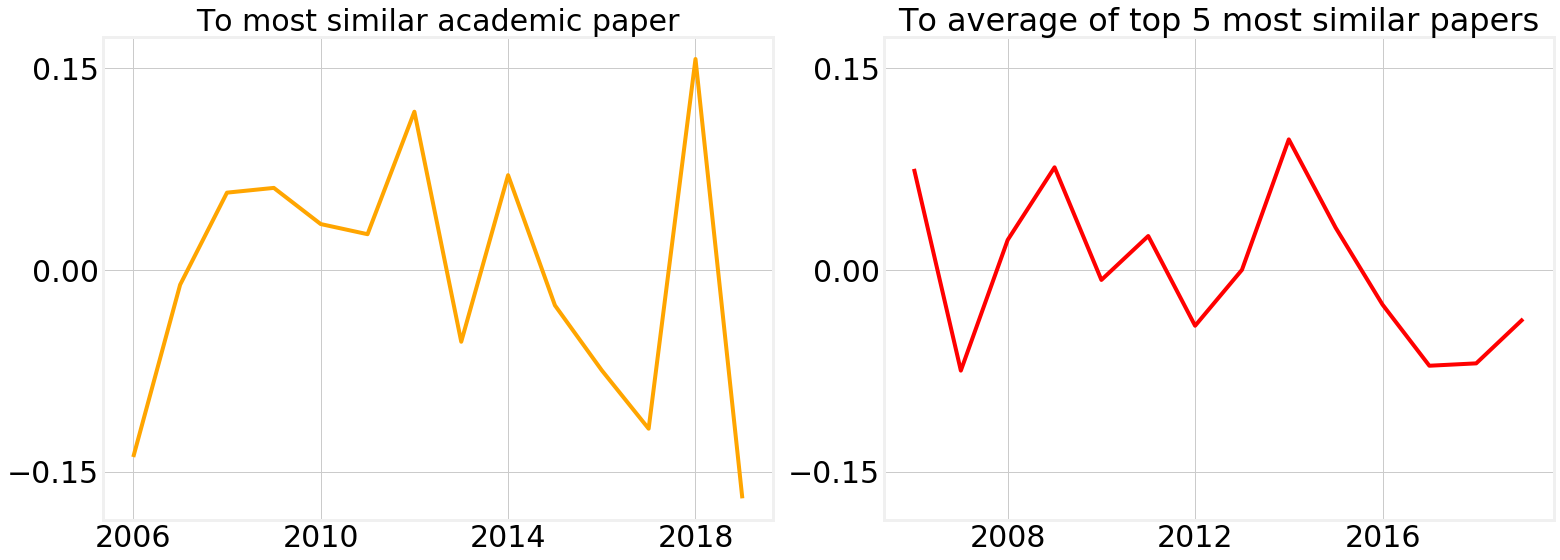

In [28]:
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(22,8),facecolor='white')

ax1 = plt.subplot2grid(shape=(1,2), loc=(0,0), colspan=1)
ax2 = plt.subplot2grid(shape=(1,2), loc=(0,1), colspan=1, sharey=ax1)

for ax in [ax1, ax2]:
    # Clear x axis ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.tick_params(axis = 'both', which = 'major', labelsize = 30)
    #ax.grid(False)
    ax.set_facecolor('white')


top    = sims_ave_cb_df.groupby(['year']).mean()["distance_std"]
ave    = sims_ave_aca_df.groupby(['year']).mean()["distance_std"]

ax1.plot(top, color="orange")
ax1.set_title("To most similar academic paper",fontsize=30)

ax2.plot(ave, color="red")
ax2.set_title("To average of top 5 most similar papers",fontsize=32)

x0 = int(ax1.get_xlim()[0]) # left boundary of x-axis (plot reference point)
gfc = x0+4

plt.tight_layout()
plt.savefig('cosine__cb_rev.pdf',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()


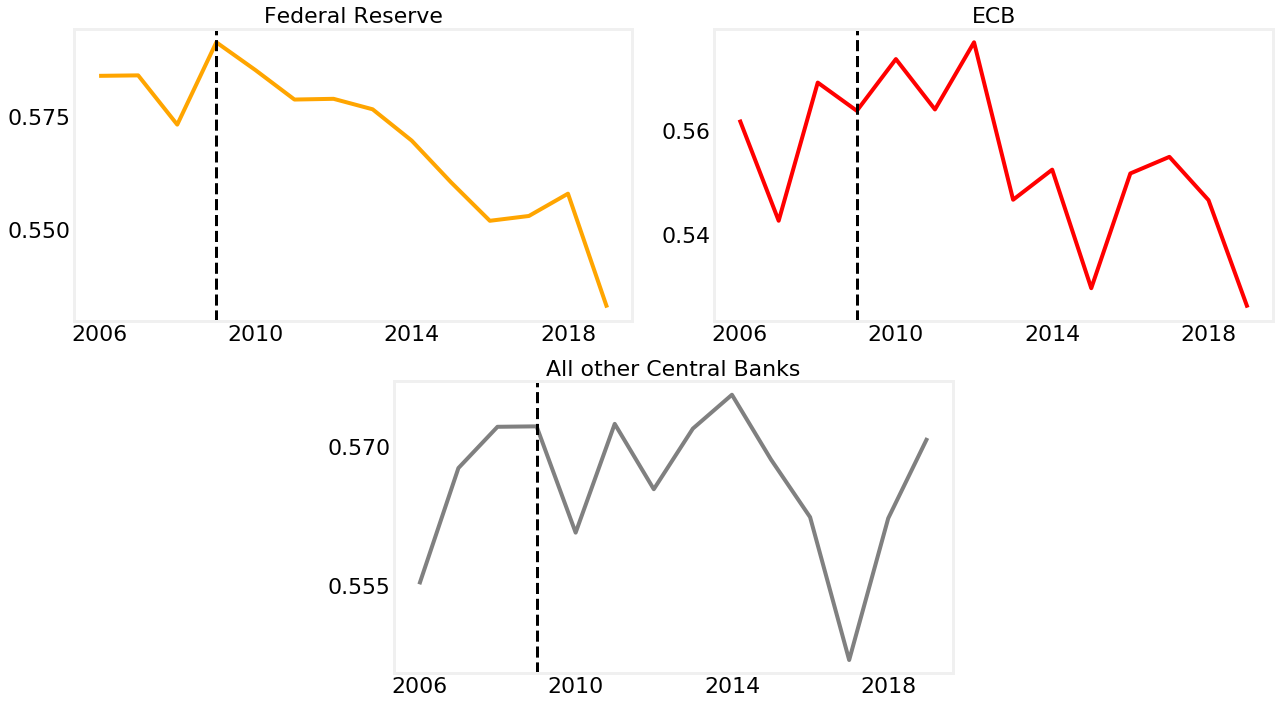

In [29]:
sims_ave = pd.DataFrame(sims_ave)
sims_ave['year'] = all_cb_data.Year
sims_ave['CB'] = all_cb_data.Central_Bank

fig = plt.figure(figsize=(18,10),facecolor='white')

ax1 = plt.subplot2grid(shape=(2,4), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid(shape=(2,4), loc=(0,2), colspan=2)
ax3 = plt.subplot2grid(shape=(2,4), loc=(1,1), colspan=2)

for ax in [ax1, ax2, ax3]:
    # Clear x axis ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.tick_params(axis = 'both', which = 'major', labelsize = 22)
    ax.grid(False)
    ax.set_facecolor('white')

fed    = sims_ave[(sims_ave.CB == 'US')].groupby(['year']).mean()
ecb    = sims_ave[(sims_ave.CB == 'ECB')].groupby(['year']).mean()
others = sims_ave[sims_ave.CB.isin(['BoE','BoC','RBA','RBNZ','BoJ','Norges','Riksbank'])].groupby(['year']).mean()

ax1.plot(fed, color="orange")
ax1.set_title("Federal Reserve",fontsize=22)

ax2.plot(ecb, color="red")
ax2.set_title("ECB",fontsize=22)

ax3.plot(others, color="grey")
ax3.set_title("All other Central Banks",fontsize=22)

x0 = int(ax1.get_xlim()[0]) # left boundary of x-axis (plot reference point)
gfc = x0+3

ax1.axvline(gfc,ls='--',c='k',lw=3,label='test start')
ax2.axvline(gfc,ls='--',c='k',lw=3,label='test start')
ax3.axvline(gfc,ls='--',c='k',lw=3,label='test start')

plt.tight_layout()
plt.savefig('cosine_ave.pdf',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()